## Molecular Solubility Prediciton Model

This is an application of linear regression to predict aqueous molecular solubility. This is a reproduction of the work conducted by John S. Delaney ("ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure" in *J. Chem. Inf. Comput. Sci.*). The dataset used herein is supplementary information obtained from: https://pubs.acs.org/doi/pdf/10.1021/ci034243x

Aqueous solubility is one of the most important physico-chemical properties in modern drug discovery. LogS is a unit of expressing solubility in itself, which is the 10-based logarithm of the solubility measured in mol/l. So you can calculate the solubility in three units: logS, mol/l, and mg/ml.



#### Install rdkit

RDKit is a cheminformatics/machine learning library that provides easy manipulation of molecules.

In [ ]:
! pip install rdkit-pypi

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
#download dataset
! wget https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt

--2022-04-07 18:30:12--  https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt
Resolving pubs.acs.org (pubs.acs.org)... 104.18.0.20, 104.18.1.20
Connecting to pubs.acs.org (pubs.acs.org)|104.18.0.20|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt?cookieSet=1 [following]
--2022-04-07 18:30:12--  https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt?cookieSet=1
Reusing existing connection to pubs.acs.org:443.
HTTP request sent, awaiting response... 302 Found
Location: https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt [following]
--2022-04-07 18:30:12--  https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt
Reusing existing connection to pubs.acs.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 60034 (59K

#### Read Dataset

In [8]:
#read dataset into pandas dataframe
import pandas as pd

In [9]:
data = pd.read_csv('delaney.csv')
data

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


In [10]:
#SMILES=Simplified Molecular Input Line Entry System (chemical structure notation)
#ESOL=Estimated Solubility

In [11]:
data.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

In [12]:
data.SMILES[0]

'ClCC(Cl)(Cl)Cl'

#### Convert SMILES compounds to rdkit Objects

In [13]:
from rdkit import Chem

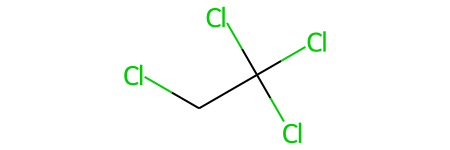

In [15]:
m=Chem.MolFromSmiles(data.SMILES[0])
m

In [16]:
m.GetNumAtoms()

6

In [17]:
#create list of rdkit objects
m_list= [Chem.MolFromSmiles(compound) for compound in data.SMILES]
print(f'There are {len(m_list)} compounds in the dataset.')
m_list[:5]

There are 1144 compounds in the dataset.


#### Calculate molecular properties/descriptors (X variables)
To predict LogS (log of the aqueous solubility, Y variable), the study from Delaney denotes the 4 most significant parameters to be calculated:

1. LogP (Octanol-water partition coefficient)
2. MW (Molecular weight)
3. RB (Number of rotatable bonds)
4. AP (Aromatic proportion = number of aromatic atoms / total number of heavy atoms)

1-3 can be computed directly by rdkit, but 4 will be computed manually


In [18]:
import numpy as np
from rdkit.Chem import Descriptors

In [19]:
#Define function to calculate properties/descriptors 1-3:

def calc_properties(m_list):
    properties={}
    
    #1. Calculate LogP
    properties['logP'] = [Descriptors.MolLogP(m) for m in m_list]
    
    #2. Calculate MW
    properties['MolWt'] = [Descriptors.MolWt(m) for m in m_list]
    
    #3. Calculate # rotatable bonds
    properties['NumRotatableBonds'] = [Descriptors.NumRotatableBonds(m) for m in m_list]
    
    #4. Calculate aromatic proportion
    
    #determine number of aromatic atoms in each compound
    n_aromatic_atoms=[]
    for i in range(len(m_list)):
        is_aromatic= [m_list[i].GetAtomWithIdx(j).GetIsAromatic() for j in range(m_list[i].GetNumAtoms())]

        aromatic_atoms=0
        for boolean in is_aromatic:
            if boolean==True:
                aromatic_atoms+=1 
        n_aromatic_atoms.append(aromatic_atoms)


    #determine number of heavy atoms in each compound
    n_heavy_atoms = [Descriptors.HeavyAtomCount(m) for m in m_list]

    #determine aromatic proportion (#aromatic atoms/#heavy atoms)
    properties['AromaticProportion'] = [aromatic/heavy for aromatic,heavy in zip(n_aromatic_atoms, n_heavy_atoms)]
    
    return properties

X_properties=calc_properties(m_list)


### Create X matrix dataframe

In [20]:
X_df= pd.DataFrame(X_properties)
X_df

,logP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0,0.000000
1,2.37650,133.405,0,0.000000
2,2.59380,167.850,1,0.000000
3,2.02890,133.405,1,0.000000
4,2.91890,187.375,1,0.000000
...,...,...,...,...
1139,1.98820,287.343,8,0.000000
1140,3.42130,286.114,2,0.333333
1141,3.60960,308.333,4,0.695652
1142,2.56214,354.815,3,0.521739


### Create Y matrix dataframe
Y variable will be the experimental solubility (logS) values from the dataset. 

In [21]:
data.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [22]:
# Set Y matrix to column 2 (index 1) of dataset dataframe
# select all rows and first column
Y_df = data.iloc[:,1]
Y_df

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

### Split the data
Split the dataset 80/20 for training set/testing set.

In [23]:
#import scikitlearn dependencies

from sklearn.model_selection import train_test_split

In [24]:
#split the X and Y data
x_train,x_test,y_train,y_test=train_test_split(X_df,Y_df,test_size=0.2)

#compare shapes of training sets
print(X_df.shape)
print(x_train.shape)
print(x_test.shape)

(1144, 4)
(915, 4)
(229, 4)


### Linear Regression

In [25]:
#import scikitlearn dependencies
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
# Create linear regression object
regr = linear_model.LinearRegression()

# train the model using training sets
regr= regr.fit(x_train, y_train)


In [37]:
#Make predictions using the test data
y_pred_test = regr.predict(x_test)

#The learned coefficients represent the weight values of each X variable (slope)
print('Coefficients:', regr.coef_)
print('Intercept:', regr.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, y_pred_test))


Coefficients: [-0.73256444 -0.00677302  0.01057781 -0.36487285]
Intercept: 0.2257988125365178
Mean squared error (MSE): 0.95
Coefficient of determination (R^2): 0.80


### Linear Regression Equation

In [28]:
print(f'LogS = {regr.intercept_:.4f} {regr.coef_[0]:.4f}LogP {regr.coef_[1]:.4f}MW {regr.coef_[2]:.4f}RB {regr.coef_[3]:.4f}AP')

LogS = 0.2258 -0.7326LogP -0.0068MW 0.0106RB -0.3649AP


### Comparing Experimental vs. Predicted Solubilities/LogS

In [31]:
#import matplotlib
import matplotlib.pyplot as plt

In [40]:
#compare experimental vs. predicted values
compare_df=pd.DataFrame({'Experimental LogS': y_test, 'Predicted LogS': y_pred_test})
compare_df

,Experimental LogS,Predicted LogS
351,-0.910,-1.479773
725,-4.430,-5.276938
1051,-3.090,-3.214949
934,-2.250,-1.888091
714,-3.583,-0.531086
...,...,...
438,-4.710,-5.602844
1088,0.940,-0.729179
601,-0.850,-2.628566
422,-8.230,-5.979972


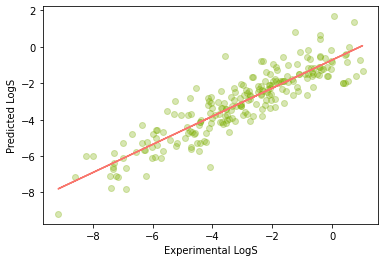

In [54]:
#Plot Experimental LogS vs Predicted LogS

plt.scatter(x=y_test, y=y_pred_test, color="#7CAE00", alpha=0.3)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
z = np.polyfit(y_test, y_pred_test, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS');